# Vehicle Detection

In [1]:
import numpy as np
import cv2
import glob
import os
from time import time    
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

C:\Users\andy.knight\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\andy.knight\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Loading data sets

In [2]:
# Read in our vehicles and non-vehicles
cars = glob.glob('train_images/vehicles/**/*.png')
notcars = glob.glob('train_images/non-vehicles/**/*.png')

print('Found ', len(cars), ' vehicle image(s)')
print('Found ', len(cars), ' non-vehicle image(s)')

Found  8792  vehicle image(s)
Found  8792  non-vehicle image(s)


## Plot pixels in 3D colour space

This can be used to evaluate how best separate vehicles from the rest of the image

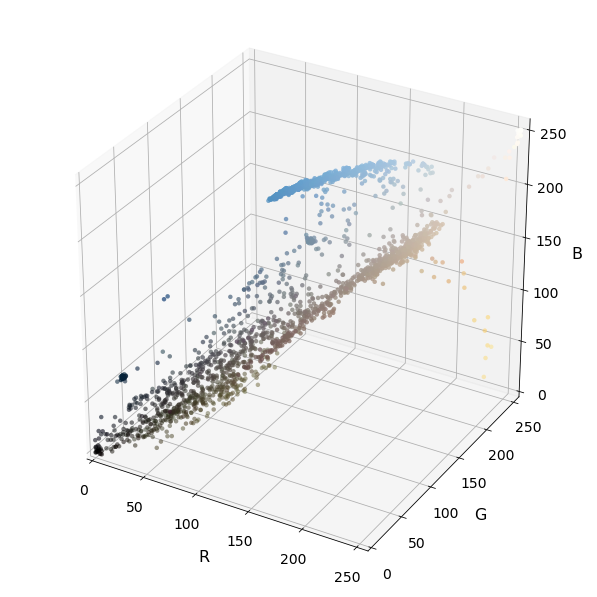

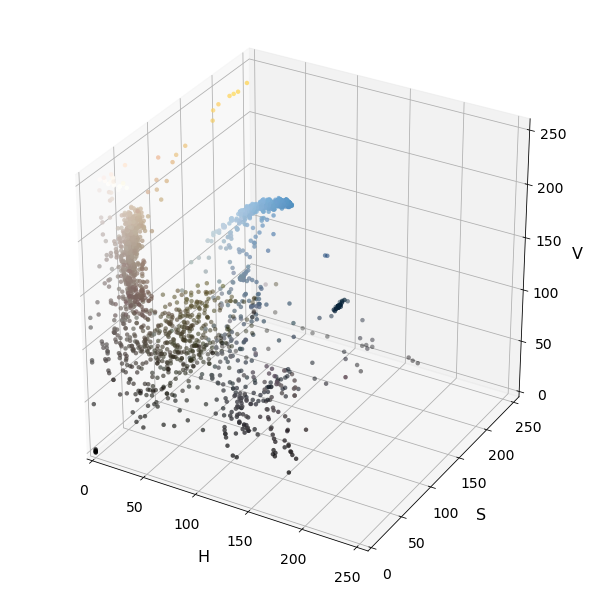

In [4]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cv2.imread('test_images/test1.jpg')

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

## Extract colour histogram features from image

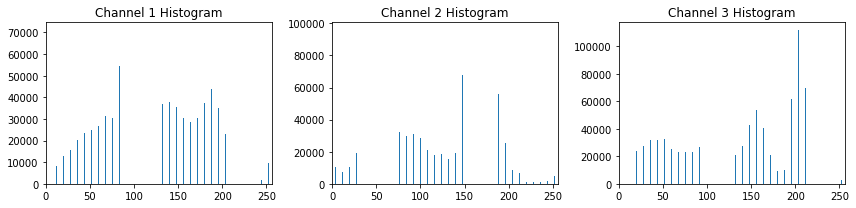

In [5]:
image = mpimg.imread('test_images/test1.jpg')

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256), plot=False):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    if(plot):
        
        # Generating bin centers
        bin_edges = channel1_hist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
        # Plot histograms
        fig = plt.figure(figsize=(12,3))
        
        plt.subplot(131)
        plt.bar(bin_centers, channel1_hist[0])
        plt.xlim(0, 256)
        plt.title('Channel 1 Histogram')
        
        plt.subplot(132)
        plt.bar(bin_centers, channel2_hist[0])
        plt.xlim(0, 256)
        plt.title('Channel 2 Histogram')
        
        plt.subplot(133)
        plt.bar(bin_centers, channel3_hist[0])
        plt.xlim(0, 256)
        plt.title('Channel 3 Histogram')
        
        fig.tight_layout()
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
    
feature_vec = color_hist(image, nbins=32, bins_range=(0, 256), plot=True)


## Extract spacial binning features from image

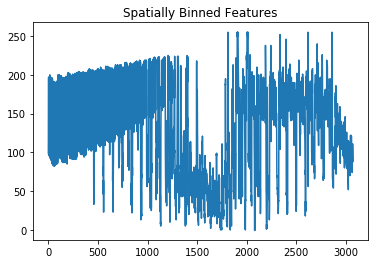

In [6]:
# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('test_images/test1.jpg')

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):          
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
    
feature_vec = bin_spatial(image, size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

## Extract HOG features from image

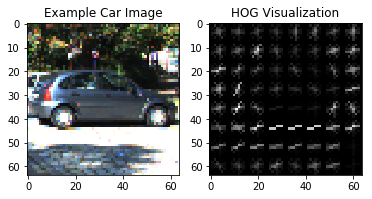

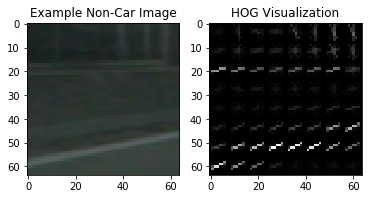

In [7]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=feature_vec)
        return features

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Generate a random index to look at a non-car image
ind = np.random.randint(0, len(notcars))
# Read in the image
notcarimage = mpimg.imread(notcars[ind])
notcargray = cv2.cvtColor(notcarimage, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, notcar_hog_image = get_hog_features(notcargray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

fig = plt.figure()
plt.subplot(121)
plt.imshow(notcarimage)
plt.title('Example Non-Car Image')
plt.subplot(122)
plt.imshow(notcar_hog_image, cmap='gray')
plt.title('HOG Visualization')


## Combine and scale features

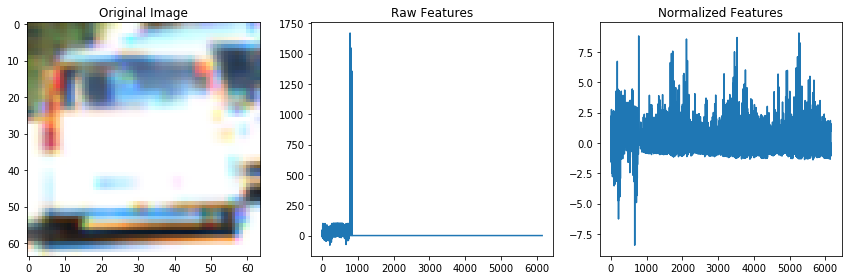

In [8]:
# Extract a variety of different features
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Feature extraction parameters
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
all_features = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
feature_scaler = StandardScaler().fit(all_features)

# Apply the scaler to features
scaled_features = feature_scaler.transform(all_features)

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))

car_ind = np.random.randint(0, len(cars))

plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')

plt.subplot(132)
plt.plot(all_features[car_ind])
plt.title('Raw Features')

plt.subplot(133)
plt.plot(scaled_features[car_ind])
plt.title('Normalized Features')

fig.tight_layout()

## Train classifier

In [9]:
# Define the labels vector
labels = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time()
svc.fit(X_train, y_train)
t2 = time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
19.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9896


## Classifier parameter tuning

In [37]:
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 2]}
#svr = SVC()
#clf = GridSearchCV(svr, parameters)
#t=time()
#clf.fit(scaled_features, labels)
#t2 = time()
#print(round(t2-t, 2), 'Seconds to search SVC parameter space...')
#print('Best parameters: ', clf.best_params_)

KeyboardInterrupt: 

## Drawing bounding boxes

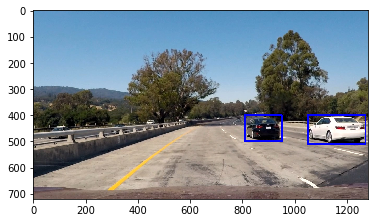

In [25]:
image = mpimg.imread('test_images/test1.jpg')

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((810, 400), (950, 500)), 
    ((1050, 400), (1270, 510))]

result = draw_boxes(image, bboxes)
plt.imshow(result)

## Sliding window across image

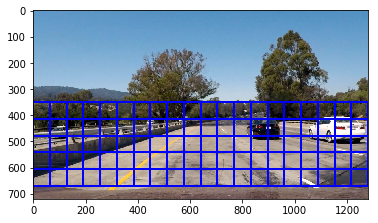

In [11]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

image = mpimg.imread('test_images/test1.jpg')

y_start = 350

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[y_start, None], xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## Search for cars in image

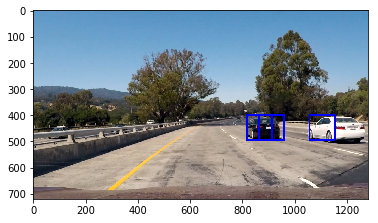

In [12]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

# Search parameters
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, feature_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

## Efficient HOG sub-sampling search for cars in images

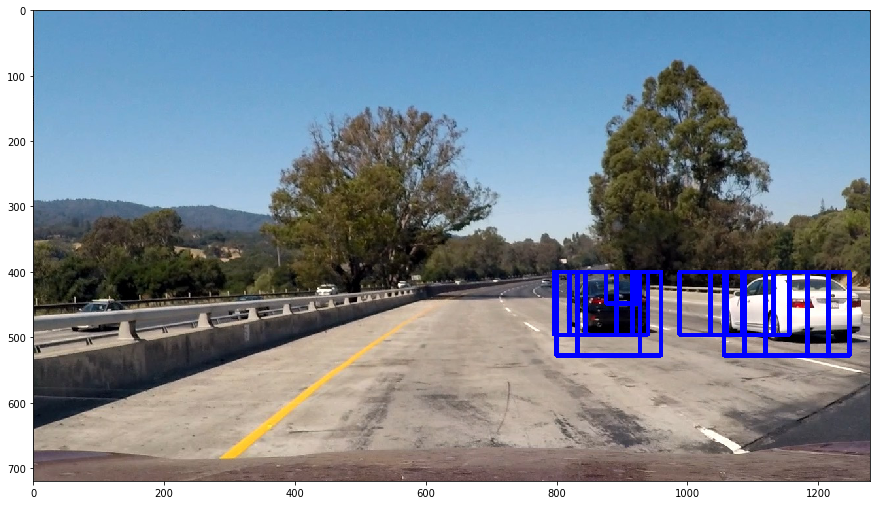

In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, feature_scaler, orient, pix_per_cell, cells_per_step, cell_per_block, spatial_size, hist_bins):
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = feature_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                box = ((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart))
                boxes.append((box))
                
    return boxes

def find_cars_all_sizes(image):
    
    cells_per_step = 2 # 75% overlap
    box_list = []

    ystart = 400
    ystop = 450
    xstart = 300
    xstop = image.shape[1] - 300
    scale = 0.75
    boxes = find_cars(image, ystart, ystop, xstart, xstop, scale, svc, feature_scaler, orient, pix_per_cell, cells_per_step, cell_per_block, spatial_size, hist_bins)
    for box in boxes:
        box_list.append(box)
    
    ystart = 400
    ystop = 475
    xstart = 200
    xstop = image.shape[1] - 200
    scale = 1.0
    boxes = find_cars(image, ystart, ystop, xstart, xstop, scale, svc, feature_scaler, orient, pix_per_cell, cells_per_step, cell_per_block, spatial_size, hist_bins)
    for box in boxes:
        box_list.append(box)

    ystart = 400
    ystop = 500
    xstart = 100
    xstop = image.shape[1] - 100
    scale = 1.5
    boxes = find_cars(image, ystart, ystop, xstart, xstop, scale, svc, feature_scaler, orient, pix_per_cell, cells_per_step, cell_per_block, spatial_size, hist_bins)
    for box in boxes:
        box_list.append(box)

    ystart = 400
    ystop = 550
    xstart = 0
    xstop = image.shape[1] - 0
    scale = 2.0
    boxes = find_cars(image, ystart, ystop, xstart, xstop, scale, svc, feature_scaler, orient, pix_per_cell, cells_per_step, cell_per_block, spatial_size, hist_bins)
    for box in boxes:
        box_list.append(box)
        
    return box_list

image = mpimg.imread('test_images/test1.jpg')

box_list = find_cars_all_sizes(image)

result = draw_boxes(image, box_list)
plt.figure(figsize=(15,15))
plt.imshow(result)

## Combining multiple detections using heat map

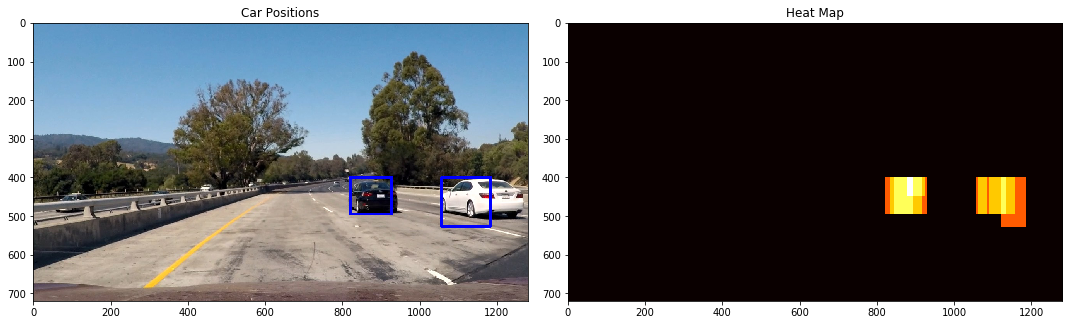

In [14]:
# Read in image similar to one shown above 
image = mpimg.imread('test_images/test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def labels_to_boxes(labels):
    # Create list of bounding boxes
    box_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Add box to list
        box_list.append(bbox)
    # Return list of bounding boxes
    return box_list

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labeled_regions = label(heatmap)
bboxes = labels_to_boxes(labeled_regions)
draw_img = draw_boxes(image, bboxes)

fig = plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Final vehicle tracking pipeline

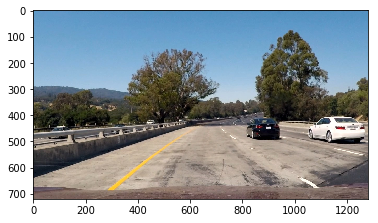

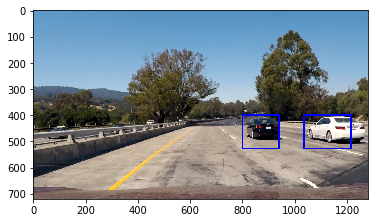

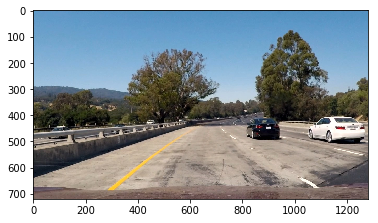

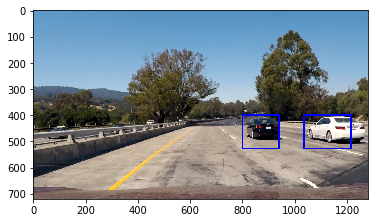

In [15]:
# Define a class to record tracking information
class VehicleTracker():
    def __init__(self):
        # TODO: Add state here
        self.bbox_buffer = []
        self.best_bboxes = []
        
    def process_image(self, img):
        
        HEAT_AVERAGING = 5
        HEAT_THRESHOLD = 5

        bboxes = find_cars_all_sizes(img)
        
        # Update collection of bounding boxes
        self.bbox_buffer.append(bboxes)
        if(len(self.bbox_buffer) > HEAT_AVERAGING):
            self.bbox_buffer = self.bbox_buffer[1:]
        
        # Initialise heat
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        
        # For each set of bounding boxes
        for box_list in self.bbox_buffer:
            # Add heat to each box in box list
            heat = add_heat(heat, box_list)
            
        # Apply threshold to help remove false positives
        threshold = max(1, HEAT_THRESHOLD * len(self.bbox_buffer) / HEAT_AVERAGING)
        heat = apply_threshold(heat, threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        
        # Find final boxes from heatmap using label function
        labeled_regions = label(heatmap)
        
        # Turn into bounding boxes
        bboxes = labels_to_boxes(labeled_regions)
        
        if False:
            # Associate with existing bboxes
            new_bboxes = []
            for new in bboxes:
                # Calculate max overlap with existing bboxes
                iMax = -1
                max_overlap = 0
                for i in range(0, len(self.best_bboxes)):
                    overlap = VehicleTracker.overlap(new, self.best_bboxes[i])
                    if overlap > max_overlap:
                        iMax = i
                        max_overlap = overlap

                # If we have found a match update it
                if max_overlap > 0.1:
                    new_bboxes.append(VehicleTracker.update(new, self.best_bboxes[iMax]))
                else:
                    new_bboxes.append(new)
            self.best_bboxes = new_bboxes
            
        else:
            # Update directly to new boxes - no tracking/smoothing
            self.best_bboxes = bboxes

        # Draw results on image
        result = img.copy()
        #for box_list in self.bbox_buffer:
        #    result = draw_boxes(result, box_list, color=(255,0,0))
        #result = draw_boxes(result, bboxes, color=(0,255,0))
        result = draw_boxes(result, self.best_bboxes)
        
        return result
    
    def overlap(bbox1, bbox2):
        left = max(bbox1[0][0], bbox2[0][0])
        right = min(bbox1[1][0], bbox2[1][0])
        bottom = max(bbox1[0][1], bbox2[0][1])
        top = min(bbox1[1][1], bbox2[1][1])
        
        area1 = (bbox1[1][0] - bbox1[0][0]) * (bbox1[1][1] - bbox1[0][1])
        area2 = (bbox1[1][0] - bbox1[0][0]) * (bbox1[1][1] - bbox1[0][1])
        overlap = (right - left) * (top - bottom) / ((area1 + area2) / 2)
        
        return overlap
    
    def update(new, existing):
        
        gain = 0.1
        
        left = int(existing[0][0] + gain * (new[0][0] - existing[0][0]))
        bottom = int(existing[0][1] + gain * (new[0][1] - existing[0][1]))
        right = int(existing[1][0] + gain * (new[1][0] - existing[1][0]))
        top = int(existing[1][1] + gain * (new[1][1] - existing[1][1]))
        
        return ((left, bottom), (right, top))
        
    
tracker = VehicleTracker()

img = mpimg.imread('test_images/test1.jpg')

plt.figure()
plt.imshow(img)

result = tracker.process_image(img)
plt.figure()
plt.imshow(result)

plt.figure()
plt.imshow(img)

result = tracker.process_image(img)
plt.figure()
plt.imshow(result)

# Lane Detection

## Camera calibration

In [38]:
# Calibration image properties
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

# List all calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the calibration images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (8,5,0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # (x,y) coordinates

for fname in images:
    
    # Read in calibration image
    img = mpimg.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Add detected object and image points
        imgpoints.append(corners)
        objpoints.append(objp)
        
# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

def cal_undistort(img, mtx, dist):
    
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

## Thresholding

In [39]:
# Calculate derivatives from image
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate sobel in either x or y direction
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # Take absolute of gradient
    abs_sobel = np.absolute(sobel)
    
    # scale value from 0 to 255
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Create binary image based on thresholds
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output
    
def red_threshold(img, thresh=(200, 255)):
    # Extract red component
    R = img[:,:,0]
    
    # Apply threshold
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    return binary

def saturation_threshold(img, thresh=(90, 255)):
    # Convert to HLS colour space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Extract saturation component
    S = hls[:,:,2]
    
    # Apply threshold
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary

def hue_threshold(img, thresh=(15, 100)):
    # Convert to HLS colour space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Extract hue component
    H = hls[:,:,0]
    
    # Apply threshold
    binary = np.zeros_like(H)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    
    return binary

def combined_threshold(img, plot=False):

    # Combine line detection methods
    r_binary = red_threshold(img, thresh=(190, 255))
    sx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=11, thresh=(20,100))
    s_binary = saturation_threshold(img, thresh=(90, 255))
    h_binary = hue_threshold(img, thresh=(10, 100))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[((s_binary == 1) & (h_binary == 1)) | ((sx_binary == 1) & (r_binary == 1))] = 1
    
    if(plot):
        
        # Stack each channel to view their individual contributions in green and blue respectively
        # This returns a stack of the two binary images, whose components you can see as different colors
        color_binary = 255 * np.dstack(( r_binary, sx_binary, ((s_binary == 1) & (h_binary))))

        plt.figure()
        plt.title('R = red channel, G = x-grad, B = sat/hue')
        plt.imshow(color_binary)
    
    return combined_binary

# Size of Sobel kernel to use
ksize = 11

## Perspective Transform

In [40]:
# Four source coordinates taken from our image pixels
src = np.float32(
    [[578, 460],
     [185, 720],
     [1127, 720],
     [704, 460]])

# Four desired coordinates to produce a top down image
dst = np.float32(
    [[320, 0],
     [320, 720],
     [960, 720],
     [960, 0]])

# Conversions from metres to pixels for the warped image
xm_per_pix=3.7/700
ym_per_pix=30/720

def perspective_transform():
    return cv2.getPerspectiveTransform(src, dst)

def inv_perspective_transform():
    return cv2.getPerspectiveTransform(dst, src)
        
def warp(img, show_points=False):
    
    M = perspective_transform()
    
    img_size = (img.shape[1], img.shape[0])
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    if(show_points):
        temp = img.copy()
        pts = src.astype(int).reshape(-1,1,2)
        cv2.polylines(temp, [pts], True, (0,255,0), thickness=3)

        plt.figure()
        plt.imshow(temp)
    
        pts = dst.astype(int).reshape(-1,1,2)
        cv2.polylines(warped, [pts], True, (255,0,0), thickness=3)
    
    return warped

def unwarp(img):
    
    Minv = inv_perspective_transform()
    
    img_size = (img.shape[1], img.shape[0])
    
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)

    return unwarped

## Region of Interest

In [41]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    
    h = img.shape[0]
    w = img.shape[1]
    vertices = np.array([[
        (0.10 * w, 0), 
        (0.90 * w, 0), 
        (0.90 * w, h), 
        (0.65 * w, h),
        (0.50 * w, 0.3 * h),
        (0.35 * w, h),
        (0.10 * w, h)]],
        dtype=np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Windowing

In [42]:
# Define a class to receive the characteristics of each line detection
class Line():
    
    def __init__(self):
        # do we have an estimate for the line location
        self.detected = False  
        # time since last successfully updated
        self.missing_count = 0
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def update(self, detected, x, y, y_max, fit):
        
        MIN_CURVATURE = 300           # Minimum acceptable curvature of line
        BEST_FIT_UPDATE_GAIN = 0.25   # Update gain for fit smoothing
        CURVATURE_UPDATE_GAIN = 0.25  # Update gain for curvature
        LOST_COUNT = 5                # Number of failed line detections before declaring line lost
        
        self.allx = x
        self.ally = y
        
        if(detected):
            # Calculate and validate curvature
            curvature = Line.curvature(x, y, y_max)
            if(curvature < MIN_CURVATURE):
                detected = False
            else:
                self.current_fit = fit
                
                # Update best fit using smoothing
                if(self.best_fit is None):
                    self.best_fit = self.current_fit
                else:
                    self.best_fit = self.current_fit * BEST_FIT_UPDATE_GAIN + self.best_fit * (1 - BEST_FIT_UPDATE_GAIN)
                    
                # Update curvature using smoothing
                if(self.radius_of_curvature is None):
                    self.radius_of_curvature = curvature
                else:
                    self.radius_of_curvature = curvature * CURVATURE_UPDATE_GAIN + self.radius_of_curvature * (1 - CURVATURE_UPDATE_GAIN)
       
        # Update missing/lost status
        if(self.detected):
            self.missing_count = 0
        else:
            self.missing_count = self.missing_count + 1
        
        self.detected = True if self.missing_count < LOST_COUNT else False
        
    def curvature(x, y, y_max):
        '''
        Calculate curvature in world frame

        x, y  - x-y coordinates of lane pixels
        y_max - maximum y-coordinate for image
        '''

        # Fit polynomial to x,y in world space
        fit = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)

        # Calculate the new radii of curvature
        curverad = ((1 + (2*fit[0]*y_max*ym_per_pix + fit[1])**2)**1.5) / np.absolute(2*fit[0])

        return curverad

def window_lanes_init(binary_warped, plot=False, nwindows=9, margin=100, minpix=50, min_points=5):
    '''
    Find lanes using sliding window (without prior estimate for window)
    
    nwindows - number of windows to use moving up through the image
    margin   - half width of each window
    minpix   - minimum number of pixels required for a valid window centre position
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    y_max = binary_warped.shape[0] - 1
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    if (plot):
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if (plot):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # check if we have found enough points for line
    found_left = len(lefty) > min_points
    found_right = len(righty) > min_points
    
    # Fit a second order polynomial to each
    if(found_left):
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = np.array([0, 0, 0])
    
    if(found_right):
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = np.array([0, 0, 0])
        
    if(plot):
        # plot left and right pixels
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Plot lane lines with best fit
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    # Create lines to store information
    left = Line()
    left.update(found_left, leftx, lefty, y_max, left_fit)
    
    right = Line()
    right.update(found_right, rightx, righty, y_max, right_fit)
    
    return left, right

def window_lanes(binary_warped, left, right, margin=100, min_points=5, plot=False):
    
    left_fit = left.best_fit
    right_fit = right.best_fit

    y_max = binary_warped.shape[0] - 1
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # check if we have found enough points for line
    found_left = len(lefty) > min_points
    found_right = len(righty) > min_points
    
    # Fit a second order polynomial to each
    if(found_left):
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = np.array([0, 0, 0])
    
    if(found_right):
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = np.array([0, 0, 0])

    if(plot):
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        plt.figure()
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    # Update lines
    left.update(found_left, leftx, lefty, y_max, left_fit)
    right.update(found_right, rightx, righty, y_max, right_fit)
        
    return left, right

## Render overlay

In [43]:
def draw_overlay(binary_warped, undist, left, right):
    
    left_fit = left.best_fit
    left_curverad = left.radius_of_curvature
    leftx = left.allx
    lefty = left.ally
    
    right_fit = right.best_fit
    right_curverad = right.radius_of_curvature
    rightx = right.allx
    righty = right.ally
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    if(left.detected and right.detected):
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,60, 0))

    # Plot left and right pixels
    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0, 0, 255]
    
    Minv = inv_perspective_transform()

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 0.65, newwarp, 1.0, 0)
    
    # Calculate average radius
    avg_curverad = (left_curverad + right_curverad) / 2 if (left.detected and right.detected) else 0
    
    # Calculate centre of lane
    vehicle_centre = binary_warped.shape[1] / 2
    lane_centre = (left_fitx[-1] + right_fitx[-1]) / 2 if (left.detected and right.detected) else vehicle_centre
    vehicle_offset = (vehicle_centre - lane_centre) * xm_per_pix

    # TODO: Add text for curvature and position in lane
    textPos = (100, binary_warped.shape[0] - 100)
    cv2.putText(result, 'Radius of curvature = {:0.0f}m'.format(avg_curverad), (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255,255), thickness=3)
    cv2.putText(result, 'Vehicle is {0:0.2f}m {1} of centre'.format(abs(vehicle_offset), 'right' if vehicle_offset > 0 else 'left'), (100, 160), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255,255), thickness=3)
    
    return result

## Final lane detection pipeline

In [44]:
# Define a class to record lane tracking information
class LaneTracker():
    def __init__(self):
        self.left = Line()
        self.right = Line()
        
    def process_image(self, img, plot=False):
        # === Undistort ===
        undist = cal_undistort(img, mtx, dist)

        # === Thresholding ===
        binary = combined_threshold(undist)

        # === Perspective transform ===
        binary_warped = warp(binary)

        # === Region of interest ===
        binary_warped = region_of_interest(binary_warped)

        # === Find lane lines ===
        # Switch based on whether we already have an estimate for the lines
        if(self.left.detected and self.right.detected):
            self.left, self.right = window_lanes(binary_warped, self.left, self.right, plot=plot)
        else:
            self.left, self.right = window_lanes_init(binary_warped, plot=plot)

        # === Render overlay ===
        result = draw_overlay(binary_warped, undist, self.left, self.right)

        return result

# Combined Tracker

In [47]:
# Define a class to record vehicle and lane tracking information
class CombinedTracker():
    def __init__(self):
        self.vehicle_tracker = VehicleTracker()
        self.lane_tracker = LaneTracker()
        
    def process_image(self, img):
        result = self.vehicle_tracker.process_image(img)
        result = self.lane_tracker.process_image(result)
        return result

# Processing Video Stream

Now we will use the pipeline on the test video stream.

In [16]:
# Make sure output directory exists
output_dir = 'output_videos/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Test Video

In [48]:
# Create tracker
tracker = VehicleTracker()

# Process image data
project_output = output_dir + 'test_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
processed_clip = clip1.fl_image(tracker.process_image)
%time processed_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/test_output.mp4
[MoviePy] Writing video output_videos/test_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:16<00:00,  2.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_output.mp4 

Wall time: 17.7 s


Play the resulting video

In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Project Video

In [19]:
# Create tracker
tracker = VehicleTracker()

# Process image data
project_output = output_dir + 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
processed_clip = clip1.fl_image(tracker.process_image)
%time processed_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_output.mp4
[MoviePy] Writing video output_videos/project_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:11<00:00,  2.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_output.mp4 

Wall time: 7min 12s


Play the resulting video

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))